#  phase 2 features 

In [1]:
# Imports
import sys
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

from load_data import StockDataLoader
import warnings
warnings.filterwarnings('ignore')


## 1. Load Processed Data


In [2]:
loader = StockDataLoader(data_dir="../data", train_file="train.csv")
datasets = loader.process(train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

train_df = datasets['train']
val_df = datasets['val']
test_df = datasets['test']

print(f"Train set: {len(train_df):,} rows")
print(f"Validation set: {len(val_df):,} rows")
print(f"Test set: {len(test_df):,} rows")


STOCK DATA LOADING AND PREPROCESSING
Loading training data...
Reading from: ../data/train.csv
✓ Loaded 21,033,522 rows
✓ Data loaded: 21,033,522 rows, 5000 unique tickers
  Date range: 1962-01-02 00:00:00 to 2024-09-23 00:00:00

Handling missing values...
✓ No missing values found
  Removing 807,778 rows with invalid prices
✓ Removed 807,778 rows with invalid data
✓ Final dataset: 20,225,744 rows, 5000 unique tickers

Creating target labels (prediction horizon: 30 trading days)...
✓ Created target labels
  Removed 150,000 rows without future prices (last 30 days per ticker)
  Final dataset: 20,075,744 rows
  Target distribution:
    ↑ (Higher): 10,848,766 (54.04%)
    ↓ (Lower): 9,226,978 (45.96%)

Splitting data into train/validation/test sets...
  Ratios: Train=70.0%, Val=15.0%, Test=15.0%
✓ Data split completed:
  Train: 5,505,350 rows (27.42%)
    Date range: 1962-01-02 00:00:00 to 2005-10-25 00:00:00
  Validation: 5,475,700 rows (27.28%)
    Date range: 2005-10-26 00:00:00 to 2015

In [3]:
from feature_utils import create_features
import gc

gc.collect()
print("Imported create_features from feature_utils (includes Ticker-based ticker_mean_return_30d).")

Imported create_features from feature_utils (includes Ticker-based ticker_mean_return_30d).


## 3. Create features for all splits

Build the full feature set for train, validation, and test. Val and test use Ticker stats from train to avoid leakage. Run this cell before the “Feature importance” section.

In [4]:
# Build all features for train, then val/test (val/test use train’s Ticker stats to avoid leakage)
print("Building features for train set…")
train_df, feature_cols = create_features(train_df)

if "ticker_mean_return_30d" not in train_df.columns:
    raise RuntimeError(
        "ticker_mean_return_30d is missing. Restart the kernel and ensure "
        "notebooks/feature_utils.py is up to date (it should define the Ticker-based feature)."
    )
ticker_stats = train_df.groupby("Ticker")["ticker_mean_return_30d"].last()
print(f"Train: {len(feature_cols)} features.")

print("Building features for validation set…")
val_df, _ = create_features(val_df, ticker_stats=ticker_stats)
print("Validation: done.")

print("Building features for test set…")
test_df, _ = create_features(test_df, ticker_stats=ticker_stats)
print("Test: done.")

print(f"Total: {len(feature_cols)} features.")


Building features for train set…
  [1/7] Basic price features...
  [2/7] Technical indicators (RSI, MACD, Bollinger)...
  [3/7] Volume features...
  [4/7] Rolling statistics...
  [5/7] Seasonality features...
  [6/7] Long-term features (MA, volatility, trend)...
  [7/7] Market regime & interactions...
  Cleaning up NaN/Inf values...
  Done!
Train: 132 features.
Building features for validation set…
  [1/7] Basic price features...
  [2/7] Technical indicators (RSI, MACD, Bollinger)...
  [3/7] Volume features...
  [4/7] Rolling statistics...
  [5/7] Seasonality features...
  [6/7] Long-term features (MA, volatility, trend)...
  [7/7] Market regime & interactions...
  Cleaning up NaN/Inf values...
  Done!
Validation: done.
Building features for test set…
  [1/7] Basic price features...
  [2/7] Technical indicators (RSI, MACD, Bollinger)...
  [3/7] Volume features...
  [4/7] Rolling statistics...
  [5/7] Seasonality features...
  [6/7] Long-term features (MA, volatility, trend)...
  [7/7] 

## 3.5. Feature importance and selection

We keep the most useful features and drop low-importance and highly correlated ones. The Ticker-based `ticker_mean_return_30d` is always kept.

Feature importance — using features built in the previous cell.
Using a sample of 500,000 rows for importance…
Sample: 500,000 rows × 132 features. Targets: 55.5% up.

--- Mutual information ---
Computing (this can take a few minutes)…
Top 20 by importance:
        feature  mutual_info
   price_max_50     0.128158
   price_min_50     0.127792
  price_min_100     0.116875
  price_max_100     0.111325
   close_max_20     0.099920
   close_min_20     0.096602
  price_min_200     0.086596
  price_max_200     0.082855
   close_max_10     0.066728
   close_min_10     0.065572
 close_range_20     0.055141
 is_bull_market     0.048675
    close_min_5     0.045258
    close_max_5     0.042999
trend_direction     0.039622
 close_range_10     0.035668
  close_range_5     0.023321
    close_lag_1     0.022674
    close_lag_2     0.022523
   close_lag_10     0.022314
Bottom 10 (lowest):
                       feature  mutual_info
                  volume_lag_2     0.001050
                volume_to

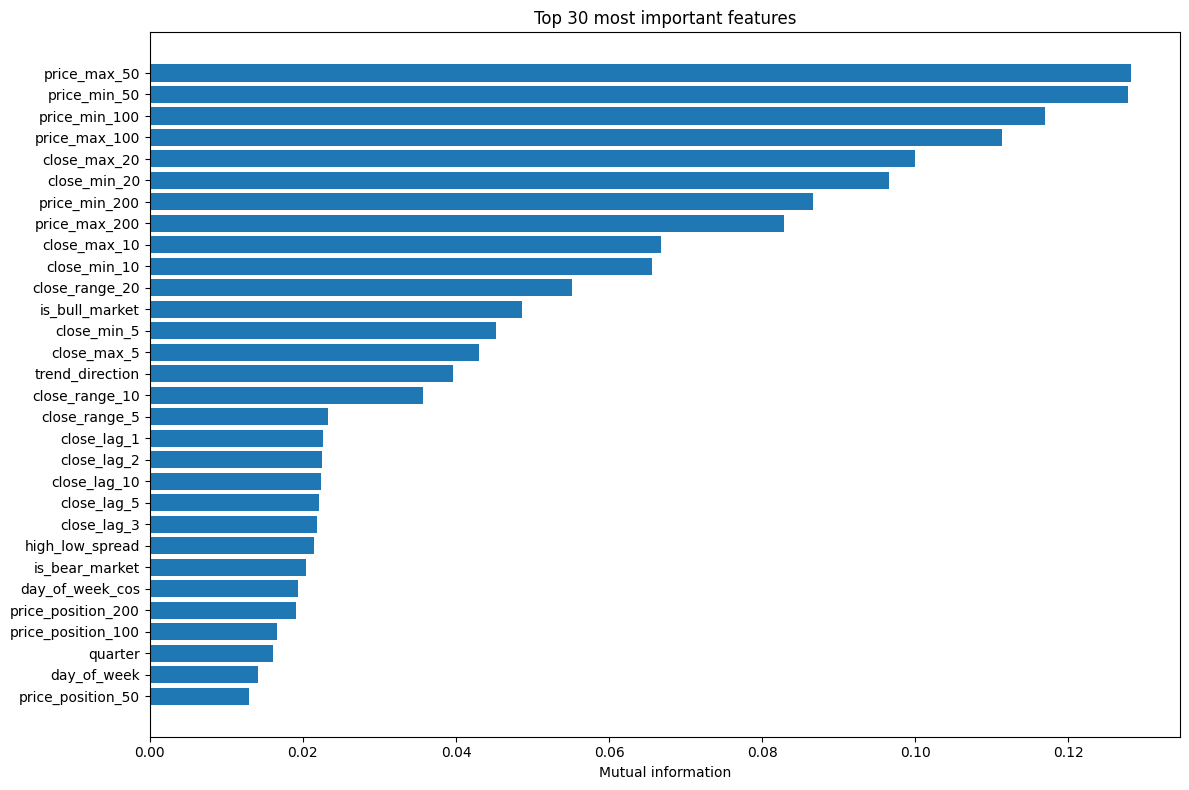

In [ ]:
print("Feature importance — using features built in the previous cell.")

if "feature_cols" not in globals() or "train_df" not in globals() or feature_cols is None:
    raise RuntimeError("Run the ‘Create features’ cell above first so feature_cols and train_df exist.")
missing = [c for c in feature_cols if c not in train_df.columns]
if missing:
    raise RuntimeError("Some feature names are missing in train_df. Run the ‘Create features’ cell first. Missing (first 5): " + str(missing[:5]))

SAMPLE_SIZE_FOR_ANALYSIS = 500_000
print(f"Using a sample of {SAMPLE_SIZE_FOR_ANALYSIS:,} rows for importance…")
train_sample = train_df.sample(n=min(SAMPLE_SIZE_FOR_ANALYSIS, len(train_df)), random_state=42)
X_sample = train_sample[feature_cols].values
y_sample = train_sample["target"].values
print(f"Sample: {X_sample.shape[0]:,} rows × {X_sample.shape[1]} features. Targets: {y_sample.mean()*100:.1f}% up.")


print("\n--- Mutual information ---")
print("Computing (this can take a few minutes)…")

mi_scores = mutual_info_classif(X_sample, y_sample, random_state=42, n_jobs=-1)

feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

print("Top 20 by importance:")
print(feature_importance_df.head(20).to_string(index=False))
print("Bottom 10 (lowest):")
print(feature_importance_df.tail(10).to_string(index=False))

# 2. Correlation
print("\n--- Correlation ---")
print("Computing…")

corr_matrix = pd.DataFrame(X_sample, columns=feature_cols).corr().abs()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.95:  # Correlation threshold
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values("correlation", ascending=False)
    print(f"Found {len(high_corr_pairs)} highly correlated pairs (r > 0.95); showing first 10:")
    print(high_corr_df.head(10).to_string(index=False))
else:
    print("No highly correlated pairs (r > 0.95).")

# 3. Selection: drop very low MI and one from each highly correlated pair
print("\n--- Selection ---")
low_importance_threshold = 0.001
low_importance_features = feature_importance_df[
    feature_importance_df["mutual_info"] < low_importance_threshold
]["feature"].tolist()
print(f"Very low importance (MI < {low_importance_threshold}): {len(low_importance_features)}. Examples: {low_importance_features[:10]}")

# From each highly correlated pair, drop the one with lower MI
features_to_remove = set(low_importance_features)
if high_corr_pairs:
    for pair in high_corr_pairs:
        m1 = feature_importance_df.loc[feature_importance_df["feature"] == pair["feature1"], "mutual_info"].values[0]
        m2 = feature_importance_df.loc[feature_importance_df["feature"] == pair["feature2"], "mutual_info"].values[0]
        features_to_remove.add(pair["feature1"] if m1 < m2 else pair["feature2"])

# Keep top 85 by MI, minus those we decided to remove
TOP_FEATURES_COUNT = 85
top_by_mi = feature_importance_df.head(TOP_FEATURES_COUNT)["feature"].tolist()
selected_features = [f for f in top_by_mi if f not in features_to_remove]

# If we dropped too many, top up from the next-best list
if len(selected_features) < 70:
    remaining = [f for f in top_by_mi if f not in selected_features]
    selected_features.extend(remaining[: 70 - len(selected_features)])

# Always keep the Ticker-based feature (useful for time series)
if "ticker_mean_return_30d" not in selected_features and "ticker_mean_return_30d" in feature_cols:
    selected_features.append("ticker_mean_return_30d")

feature_cols = selected_features
print(f"Started with {len(feature_importance_df)} features. Removed {len(low_importance_features)} low-importance, {len(features_to_remove) - len(low_importance_features)} from correlated pairs.")
print(f"Selected: {len(feature_cols)} features ({100 * (len(feature_importance_df) - len(feature_cols)) / len(feature_importance_df):.1f}% reduction).")

# Plot top 30 by importance
plt.figure(figsize=(12, 8))
top30 = feature_importance_df.head(30)
plt.barh(range(len(top30)), top30["mutual_info"].values)
plt.yticks(range(len(top30)), top30["feature"].values)
plt.xlabel("Mutual information")
plt.title("Top 30 most important features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../data/processed/feature_importance.png", dpi=150, bbox_inches="tight")
print("Saved plot to ../data/processed/feature_importance.png")
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler

print("Cleaning: replacing inf and NaN in the selected features…")
for df in (train_df, val_df, test_df):
    arr = df[feature_cols].to_numpy()
    mask = ~np.isfinite(arr)
    if mask.any():
        arr[mask] = 0.0
        df[feature_cols] = arr
print("Done. Casting to float32.")
for df in (train_df, val_df, test_df):
    df[feature_cols] = df[feature_cols].astype("float32")

# Fit scaler on a sample of training data to avoid memory issues
scaler = StandardScaler()
max_samples_for_scaler = 1_000_000
if len(train_df) > max_samples_for_scaler:
    sample = train_df[feature_cols].sample(
        n=max_samples_for_scaler, random_state=42
    ).to_numpy()
else:
    sample = train_df[feature_cols].to_numpy()

print(f"Fitting scaler on {sample.shape[0]:,} samples…")
scaler.fit(sample)

def transform_in_batches(df, feature_cols, scaler, batch_size=200_000):
    n = len(df)
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch = df[feature_cols].iloc[start:end].to_numpy()
        batch_scaled = scaler.transform(batch)
        df.loc[df.index[start:end], feature_cols] = batch_scaled

print("Scaling train…")
transform_in_batches(train_df, feature_cols, scaler)

print("Scaling validation…")
transform_in_batches(val_df, feature_cols, scaler)

print("Scaling test…")
transform_in_batches(test_df, feature_cols, scaler)

print("Features normalized (batched).")

Cleaning: replacing inf and NaN in the selected features…
Done. Casting to float32.
Fitting scaler on 1,000,000 samples…
Scaling train…
Scaling validation…
Scaling test…
Features normalized (batched).


In [7]:
output_dir = Path("../data/processed")
output_dir.mkdir(exist_ok=True)
save_cols = ["Date", "Ticker", "target"] + feature_cols

print(f"Saving data ({len(feature_cols)} features)…")
train_df[save_cols].to_csv(output_dir / "train_features.csv", index=False)
val_df[save_cols].to_csv(output_dir / "val_features.csv", index=False)
test_df[save_cols].to_csv(output_dir / "test_features.csv", index=False)

with open(output_dir / "feature_cols.pkl", "wb") as f:
    pickle.dump(feature_cols, f)
with open(output_dir / "scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

if "feature_importance_df" in globals() and feature_importance_df is not None:
    with open(output_dir / "feature_importance.pkl", "wb") as f:
        pickle.dump({
            "feature_importance_df": feature_importance_df,
            "selected_features": feature_cols,
            "removed_features": list(features_to_remove) if "features_to_remove" in globals() else [],
        }, f)
    print("Saved feature importance.")
    orig = len(feature_importance_df)
    print(f"Summary: {orig} → {len(feature_cols)} features ({100 * (orig - len(feature_cols)) / orig:.1f}% reduction).")

print(f"Saved to {output_dir}. Feature names and scaler written.")


Saving data (71 features)…
Saved feature importance.
Summary: 132 → 71 features (46.2% reduction).
Saved to ../data/processed. Feature names and scaler written.
